In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
# from pympc.control.controllers_socp import HybridModelPredictiveController
# from pympc.control.controllers_gurobi import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory

In [2]:
m = 1.
d = 1.
k = 100.
c = 10.
g = 10.
h = .02

In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [0., 0., 0.]
    ])
B1 = np.array([
    [0.],
    [1.],
    [0.]
    ])
c1 = np.array([
    [0.],
    [0.],
    [-g]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.1 (paddle pushing ball)
A3 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [-k/m, k/m, -c/m]
    ])
B3 = np.array([
    [0.],
    [1.],
    [c/m]
    ])
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

In [4]:
# state bounds
x_max = np.array([
    [2.],
    [.3],
    [5.]
])
x_min = - x_max


# input bounds
u_max = np.array([[1.]])
u_min = - u_max

# domain n.1
D1 = Polyhedron.from_bounds(
    np.vstack((x_min, u_min)),
    np.vstack((x_max, u_max))
)
D1.add_inequality(
    np.array([[-1., 1., 0., 0.]]),
    np.array([[-m*g/k]])
)
assert D1.bounded
assert not D1.empty

# domain n.2
D2 = Polyhedron.from_bounds(
    np.vstack((x_min, u_min)),
    np.vstack((x_max, u_max))
)
D2.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D2.add_inequality(
    np.array([[-k, k, -c, c]]),
    np.array([[-m*g]])
)
assert D2.bounded
assert not D2.empty

# domain n.2
D3 = Polyhedron.from_bounds(
    np.vstack((x_min, u_min)),
    np.vstack((x_max, u_max))
)
D3.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D3.add_inequality(
    np.array([[k, -k, c, -c]]),
    np.array([[m*g]])
)
assert D3.bounded
assert not D3.empty

# list of domains
D_list = [D1, D2, D3]

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

In [6]:
# controller parameters
N = 1
Q = np.diag([1.,1.,1.])
R = np.diag([1.])

# terminal set and cost
P, K = S3.solve_dare(Q, R)
X_N = S3.mcais(K, D3, verbose=True)

# hybrid controller
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'improved_big_m')

Time horizon: 16. Convergence index: -0.0007248208731225891. Number of facets: 37.   
Maximal constraint-admissible invariant set found.
Removing redundant facets ... minimal facets are 33.


In [7]:
x0 = np.array([[0.], [.0], [.0]])
u, x, ms, cost = controller.feedforward(x0)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 81 rows, 10 columns and 227 nonzeros
Model has 10 quadratic objective terms
Variable types: 7 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 76 rows and 5 columns
Presolve time: 0.00s
Presolved: 5 rows, 5 columns, 12 nonzeros
Presolved model has 7 quadratic objective terms
Variable types: 4 continuous, 1 integer (1 binary)

Root relaxation: cutoff, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.00000    0.00000  0.00%

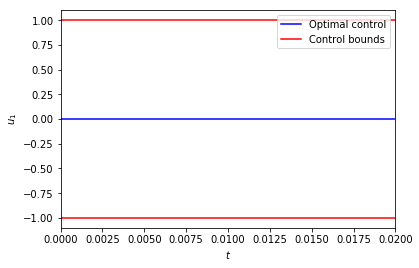

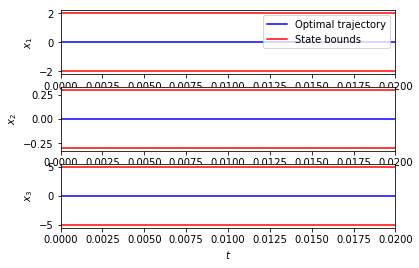

In [8]:
# input
plot_input_sequence(u, h, (u_min, u_max))
plt.show()

# output (horizontal position of the tip of the pole)
plot_state_trajectory(x, h, (x_min, x_max))
plt.show()

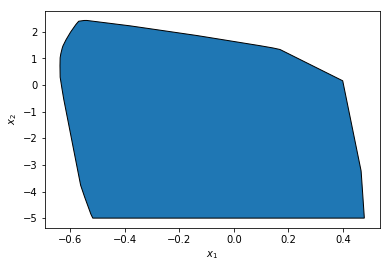

In [9]:
# feasible set (ball position and velocity)
from pympc.control.hybrid_benchmark.utils import get_constraint_set
controller.reset_program()
CS = get_constraint_set(controller.prog)
proj = CS.project_to([0,2])
proj.plot()

In [10]:
# feasible set section (given paddle valocity)
v_paddle = 0.
A_sect = np.hstack((CS.A[:, :1], CS.A[:, 2:]))
b_sect = CS.b + CS.A[:, 1:2] * v_paddle
CS_sect = Polyhedron(A_sect, b_sect)
sect = CS_sect.project_to([0,1])

In [11]:
n_samples = 201
q_samples = np.linspace(x_min[0], x_max[0], n_samples)
qd_samples = np.linspace(x_min[2], x_max[2], n_samples)
cost_mat = np.empty([n_samples]*2)
cost_mat[:] = np.nan
for i, q in enumerate(q_samples):
    for j, qd in enumerate(qd_samples):
        x0 = np.array([[q],[0.],[qd]])
        cost = controller.feedforward_relaxation(x0, [])[3]
        if cost is not None:
            cost_mat[i,j] = cost

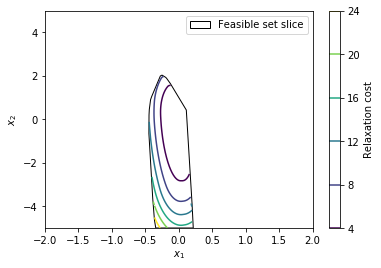

In [13]:
Q, Qd = np.meshgrid(q_samples, qd_samples)
cp = plt.contour(Q, Qd, cost_mat.T)
plt.colorbar(cp, label='Relaxation cost')
sect.plot(facecolor='w', label='Feasible set slice')
plt.legend()
plt.savefig('improved_bigm.pdf')